In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import catboost as cb

In [2]:
df = pd.read_csv('C:/Users/Kevin/Desktop/Dissertation/work/modelling/hybrid_data_1.csv')

In [3]:
df.head()

,material type,SA,TPV,C,H,N,O,T,P,CO2
0,Microporous,976.0,1.07,40.18,4.46,42.16,5.25,0,1.0,4.295
1,Microporous,976.0,1.07,40.18,4.46,42.16,5.25,25,1.0,2.795
2,Microporous,807.0,NaN,NaN,NaN,NaN,NaN,0,1.0,3.000
3,Microporous,513.0,NaN,NaN,NaN,NaN,NaN,0,1.0,2.159
4,Hierarchical,870.0,0.83,64.38,4.17,9.79,NaN,0,1.0,3.363


In [4]:
#dividing data into relevant columns
X = df.iloc[:,:-1]
y = df.CO2
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.9,random_state=0)

In [5]:
##pipelining
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_KNN",KNNImputer(n_neighbors=10)),
        ("standard_scaler",StandardScaler()),
    ]
    )

In [6]:
categorical_preprocessor = Pipeline(
    steps=[
        ("onehot",OneHotEncoder(handle_unknown="ignore")),
    ]
    )

In [7]:
preprocessor = ColumnTransformer(
    [
    ("categorical",categorical_preprocessor,["material type"]),
    ("numerical",numeric_preprocessor,['SA','TPV','C','H','N','O','T','P']),
    ]
)

In [8]:
pipe = Pipeline(
steps=[
    ("preprocessor",preprocessor),("regressor",RandomForestRegressor())
])

In [9]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['material type']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_KNN',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['SA', 'TPV', 'C', 'H', 'N',
                                                   'O', 'T', 'P'])])),
                ('regressor', RandomForestRegressor())])

In [10]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['material type']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_KNN',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['SA', 'TPV', 'C', 'H', 'N',
                                                   'O', 'T', 'P'])])),
                ('regressor', RandomForestRegressor())])

In [11]:
param_grid= {
    "regressor__n_estimators":[x for x in range(0,1000,100)],
    "regressor__max_features":["sqrt", "log2", None],
    "regressor__min_samples_split":[x for x in range(0,10,2)]
}

In [12]:
grid_search = GridSearchCV(pipe,param_grid=param_grid,n_jobs=-1)

In [13]:
grid_search.fit(X_train,y_train)

C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
210 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['material '
                                                                          'type']),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('imputation_KNN',
                                                                                          KNNImputer(n_neighbors=10)),
                                                                                         ('standard_scaler',
                                                                                          StandardScaler())]),
                                                                         ['SA',
                                                                          'TPV',
                                                                          'C',
                                                                          'H',
                                                                          'N',
                                                                          'O',
                                                                          'T',
                                                                          'P'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_features': ['sqrt', 'log2', None],
                         'regressor__min_samples_split': [0, 2, 4, 6, 8],
                         'regressor__n_estimators': [0, 100, 200, 300, 400, 500,
                                                     600, 700, 800, 900]})

In [14]:
from sklearn.metrics import r2_score
print('Train Accuracy: ',r2_score(y_train,grid_search.predict(X_train)))

Train Accuracy:  0.9561420300445291


In [16]:
print('Test Accuracy: ',r2_score(y_test,grid_search.predict(X_test)))

Test Accuracy:  0.8300241543567011


In [21]:
import joblib
final_pipeline = Pipeline(steps = [("preprocessor",preprocessor)] + [('model',grid_search)])

In [23]:
joblib.dump(grid_search,"rf_model.joblib")

['rf_model.joblib']

In [24]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
def evaluate_model(model):
    # Make predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Calculate metrics
    r2_train = r2_score(y_train, train_preds)
    r2_test = r2_score(y_test, test_preds)
    
    mse_train = mean_squared_error(y_train, train_preds)
    mse_test = mean_squared_error(y_test, test_preds)
    
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    mape_train = mean_absolute_percentage_error(y_train, train_preds)
    mape_test = mean_absolute_percentage_error(y_test, test_preds)
    
    return [r2_train, r2_test, mse_train, mse_test, rmse_train, rmse_test, mape_train, mape_test]
print(evaluate_model(grid_search))

[0.9561420300445291, 0.8300241543567011, 0.1211027749087812, 0.46478010687499804, 0.34799823980701566, 0.6817478323214515, 0.1536291291998813, 0.230423814208899]


In [17]:
#Random Forest
actual_data = df.CO2
predicted_train_data = grid_search.predict(X_train)
predicted_test_data = grid_search.predict(X_test)

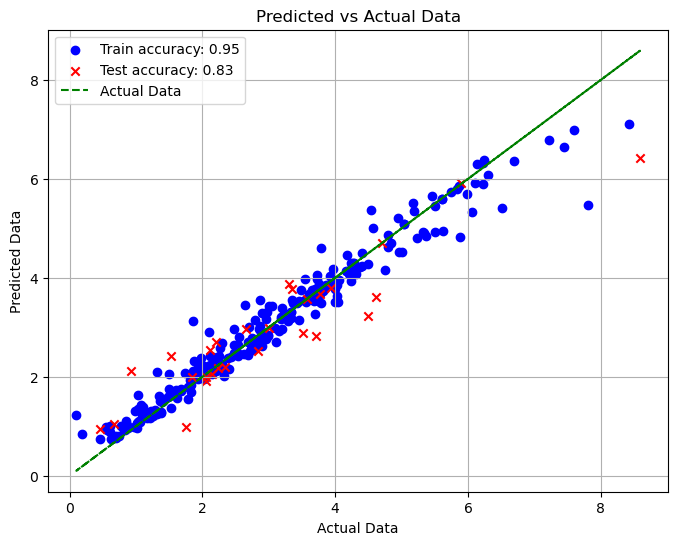

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_train, predicted_train_data, color='blue', label='Train accuracy: 0.95', marker='o')
plt.scatter(y_test, predicted_test_data, color='red', label='Test accuracy: 0.83', marker='x')
plt.plot(actual_data, actual_data, color='green', linestyle='--', label='Actual Data')

plt.title('Predicted vs Actual Data')
plt.xlabel('Actual Data')
plt.ylabel('Predicted Data')
plt.legend()
plt.grid(True)
plt.savefig('rf_plot.png')
plt.show()

In [42]:
grid_search.best_score_

0.6897449631175354

In [46]:
grid_search.best_params_

{'regressor__max_features': 'sqrt',
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 500}

In [50]:
##XGB
param_grid_xgb = {
    "regressor__learning_rate":[0.1, 0.01, 0.001],
    "regressor__max_depth":[int(x) for x in np.linspace(start=3,stop=5,num=1)],
    "regressor__n_estimators":[int(x) for x in np.linspace(start=100,stop=1000,num=10)]
                               }
pipe_1 = Pipeline(steps=[
    ("preprocessor",preprocessor),("regressor",XGBRegressor())
])
            
grid_search_1 = GridSearchCV(pipe_1,param_grid=param_grid_xgb,n_jobs=-1)
        
grid_search_1.fit(X_train,y_train)

print(grid_search_1.best_score_)
                               

0.7851137795428768


In [52]:
##LGBM
param_grid_lgbm = {
    'regressor__n_estimators':[int(x) for x in np.linspace(start=100,stop=1000,num=10)],
    'regressor__learning_rate': [0.1,0.01,0.001],
    'regressor__max_depth': [int(x) for x in np.linspace(start=3,stop=5,num=1)]
}

pipe_2 = Pipeline(
steps=[
    ("preprocessor",preprocessor),
    ("regressor",LGBMRegressor())
])

grid_search_2 = GridSearchCV(pipe_2,param_grid=param_grid_lgbm,n_jobs=-1)

grid_search_2.fit(X_train,y_train)

print(grid_search_2.best_score_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 247, number of used features: 11
[LightGBM] [Info] Start training from score 3.007567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [55]:
##GBDT
param_grid_gbdt = {
    'regressor__n_estimators':[int(x) for x in np.linspace(start=100,stop=1000,num=10)],
    'regressor__learning_rate': [0.1,0.01,0.001],
    'regressor__max_depth': [int(x) for x in np.linspace(start=3,stop=5,num=1)]
}

pipe_3 = Pipeline(
steps=[
    ("preprocessor",preprocessor),
    ("regressor",GradientBoostingRegressor())
])

grid_search_3 = GridSearchCV(pipe_3,param_grid=param_grid_gbdt,n_jobs=-1)

grid_search_3.fit(X_train,y_train)

print(grid_search_3.best_score_)

0.7482068754651072


In [56]:
##adaboost
param_grid_ada = {
    'regressor__n_estimators':[int(x) for x in np.linspace(start=100,stop=1000,num=10)],
    'regressor__learning_rate': [0.1,0.01,0.001],
    'regressor__loss': ['linear','square','exponential']
}

pipe_4 = Pipeline(
steps=[
    ("preprocessor",preprocessor),
    ("regressor",AdaBoostRegressor())
])

grid_search_4 = GridSearchCV(pipe_4,param_grid=param_grid_ada,n_jobs=-1)

grid_search_4.fit(X_train,y_train)

print(grid_search_4.best_score_)

0.6389088588636553


In [59]:
param_grid_cat = {
    'regressor__n_estimators':[int(x) for x in np.linspace(start=100,stop=1000,num=10)],
    'regressor__learning_rate': [0.1,0.01,0.001],
    'regressor__l2_leaf_reg':[None]+[1,3,5]
}

pipe_5 = Pipeline(
steps=[
    ("preprocessor",preprocessor),
    ("regressor",cb.CatBoostRegressor(loss_function='RMSE'))
])

grid_search_5 = GridSearchCV(pipe_5,param_grid=param_grid_cat,n_jobs=-1)

grid_search_5.fit(X_train,y_train)

print(grid_search_5.best_score_)

C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
7 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(

0:	learn: 1.5795810	total: 149ms	remaining: 2m 28s
1:	learn: 1.5082155	total: 150ms	remaining: 1m 14s
2:	learn: 1.4400566	total: 150ms	remaining: 50s
3:	learn: 1.3816678	total: 151ms	remaining: 37.7s
4:	learn: 1.3393327	total: 152ms	remaining: 30.3s
5:	learn: 1.2819308	total: 153ms	remaining: 25.4s
6:	learn: 1.2253665	total: 154ms	remaining: 21.9s
7:	learn: 1.1818099	total: 155ms	remaining: 19.3s
8:	learn: 1.1335454	total: 157ms	remaining: 17.2s
9:	learn: 1.1031790	total: 161ms	remaining: 15.9s
10:	learn: 1.0677338	total: 162ms	remaining: 14.6s
11:	learn: 1.0338182	total: 163ms	remaining: 13.4s
12:	learn: 1.0030308	total: 164ms	remaining: 12.4s
13:	learn: 0.9717105	total: 166ms	remaining: 11.7s
14:	learn: 0.9505451	total: 167ms	remaining: 11s
15:	learn: 0.9290246	total: 169ms	remaining: 10.4s
16:	learn: 0.9021505	total: 170ms	remaining: 9.81s
17:	learn: 0.8861280	total: 171ms	remaining: 9.34s
18:	learn: 0.8625258	total: 173ms	remaining: 8.91s
19:	learn: 0.8458288	total: 174ms	remaining

288:	learn: 0.0705817	total: 499ms	remaining: 1.23s
289:	learn: 0.0703025	total: 501ms	remaining: 1.23s
290:	learn: 0.0700731	total: 502ms	remaining: 1.22s
291:	learn: 0.0692360	total: 503ms	remaining: 1.22s
292:	learn: 0.0690298	total: 504ms	remaining: 1.22s
293:	learn: 0.0687021	total: 506ms	remaining: 1.21s
294:	learn: 0.0683697	total: 507ms	remaining: 1.21s
295:	learn: 0.0679771	total: 508ms	remaining: 1.21s
296:	learn: 0.0671695	total: 509ms	remaining: 1.21s
297:	learn: 0.0665311	total: 511ms	remaining: 1.2s
298:	learn: 0.0664799	total: 512ms	remaining: 1.2s
299:	learn: 0.0660272	total: 513ms	remaining: 1.2s
300:	learn: 0.0656910	total: 514ms	remaining: 1.19s
301:	learn: 0.0655296	total: 515ms	remaining: 1.19s
302:	learn: 0.0651446	total: 517ms	remaining: 1.19s
303:	learn: 0.0649439	total: 518ms	remaining: 1.19s
304:	learn: 0.0648228	total: 519ms	remaining: 1.18s
305:	learn: 0.0641941	total: 520ms	remaining: 1.18s
306:	learn: 0.0638198	total: 522ms	remaining: 1.18s
307:	learn: 0.0

449:	learn: 0.0307277	total: 679ms	remaining: 829ms
450:	learn: 0.0305460	total: 680ms	remaining: 828ms
451:	learn: 0.0305119	total: 681ms	remaining: 826ms
452:	learn: 0.0303705	total: 683ms	remaining: 825ms
453:	learn: 0.0301692	total: 684ms	remaining: 823ms
454:	learn: 0.0300187	total: 686ms	remaining: 822ms
455:	learn: 0.0299609	total: 688ms	remaining: 820ms
456:	learn: 0.0298620	total: 689ms	remaining: 819ms
457:	learn: 0.0295142	total: 690ms	remaining: 817ms
458:	learn: 0.0293058	total: 691ms	remaining: 815ms
459:	learn: 0.0292673	total: 693ms	remaining: 813ms
460:	learn: 0.0291275	total: 694ms	remaining: 812ms
461:	learn: 0.0290330	total: 696ms	remaining: 811ms
462:	learn: 0.0288137	total: 698ms	remaining: 809ms
463:	learn: 0.0287696	total: 699ms	remaining: 808ms
464:	learn: 0.0285569	total: 700ms	remaining: 806ms
465:	learn: 0.0283005	total: 702ms	remaining: 804ms
466:	learn: 0.0281272	total: 703ms	remaining: 802ms
467:	learn: 0.0279880	total: 704ms	remaining: 801ms
468:	learn: 

612:	learn: 0.0157307	total: 857ms	remaining: 541ms
613:	learn: 0.0155943	total: 858ms	remaining: 539ms
614:	learn: 0.0155231	total: 859ms	remaining: 538ms
615:	learn: 0.0154648	total: 861ms	remaining: 537ms
616:	learn: 0.0153376	total: 862ms	remaining: 535ms
617:	learn: 0.0152777	total: 863ms	remaining: 534ms
618:	learn: 0.0152025	total: 865ms	remaining: 532ms
619:	learn: 0.0150909	total: 866ms	remaining: 531ms
620:	learn: 0.0149926	total: 867ms	remaining: 529ms
621:	learn: 0.0149277	total: 868ms	remaining: 528ms
622:	learn: 0.0149090	total: 869ms	remaining: 526ms
623:	learn: 0.0148195	total: 870ms	remaining: 525ms
624:	learn: 0.0147531	total: 872ms	remaining: 523ms
625:	learn: 0.0146931	total: 873ms	remaining: 522ms
626:	learn: 0.0146559	total: 874ms	remaining: 520ms
627:	learn: 0.0145534	total: 876ms	remaining: 519ms
628:	learn: 0.0144996	total: 877ms	remaining: 517ms
629:	learn: 0.0144678	total: 878ms	remaining: 515ms
630:	learn: 0.0142990	total: 878ms	remaining: 514ms
631:	learn: 

911:	learn: 0.0045233	total: 1.22s	remaining: 117ms
912:	learn: 0.0045089	total: 1.22s	remaining: 116ms
913:	learn: 0.0044967	total: 1.22s	remaining: 115ms
914:	learn: 0.0044814	total: 1.22s	remaining: 113ms
915:	learn: 0.0044772	total: 1.22s	remaining: 112ms
916:	learn: 0.0044596	total: 1.22s	remaining: 111ms
917:	learn: 0.0044576	total: 1.22s	remaining: 109ms
918:	learn: 0.0044439	total: 1.22s	remaining: 108ms
919:	learn: 0.0044247	total: 1.23s	remaining: 107ms
920:	learn: 0.0044172	total: 1.23s	remaining: 105ms
921:	learn: 0.0043856	total: 1.23s	remaining: 104ms
922:	learn: 0.0043752	total: 1.23s	remaining: 103ms
923:	learn: 0.0043728	total: 1.23s	remaining: 101ms
924:	learn: 0.0043712	total: 1.23s	remaining: 99.9ms
925:	learn: 0.0043354	total: 1.23s	remaining: 98.6ms
926:	learn: 0.0043285	total: 1.23s	remaining: 97.2ms
927:	learn: 0.0043181	total: 1.24s	remaining: 95.9ms
928:	learn: 0.0043044	total: 1.24s	remaining: 94.6ms
929:	learn: 0.0042894	total: 1.24s	remaining: 93.2ms
930:	l